In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../functions')
from model import get_unet
from data import load_data
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/home/will/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x, y = load_data('../data/')

100%|██████████| 5088/5088 [00:06<00:00, 759.05it/s]


In [3]:
model = get_unet(input_shape = (128, 128, 3), batchnorm = True)
model.load_weights('../weights/unet_weights.h5')

In [4]:
predictions = []
for im in tqdm(x):
    prediction = np.expand_dims(model.predict(np.expand_dims(im, axis = 0))[0, :, :, 0] > .2, axis = 2)
    predictions.append(np.multiply(im, np.concatenate([prediction for _ in range(3)], axis = 2)))

100%|██████████| 5088/5088 [12:00<00:00,  7.23it/s]


In [65]:
colors = np.mean(np.mean(predictions, axis = 1), axis = 1)
color_ratios = np.array([[color[1] / color[0], color[1] / color[2], color[0] / color[2]] for color in colors])

In [108]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.1, min_samples = 10)
db.fit(color_ratios)
set(db.labels_)

{-1, 0, 1, 2, 3}

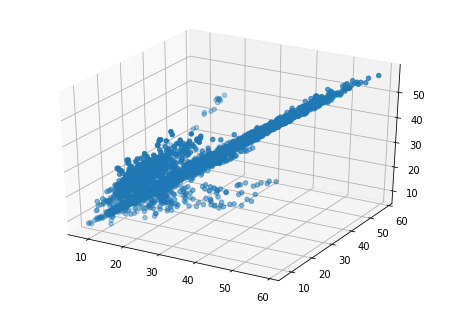

In [67]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(colors[:, 0], colors[:, 1], colors[:, 2])
pyplot.show()

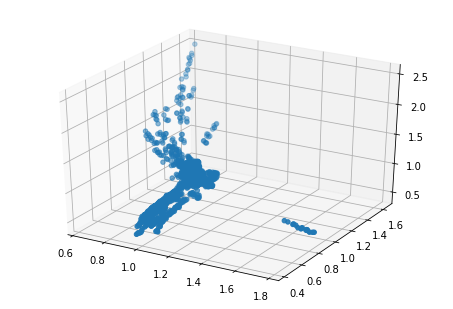

In [87]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(color_ratios[:, 0], color_ratios[:, 1], color_ratios[:, 2])
pyplot.show()

Estimated number of clusters: 12
Estimated number of noise points: 699


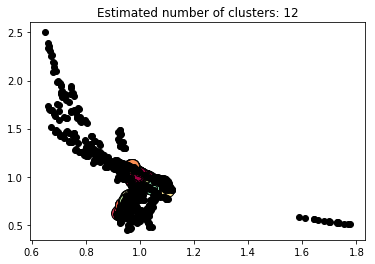

In [78]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.01, min_samples=10).fit(color_ratios)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = color_ratios[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = color_ratios[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

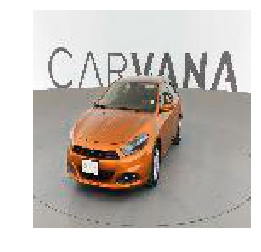

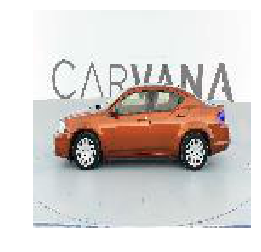

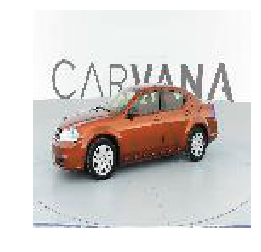

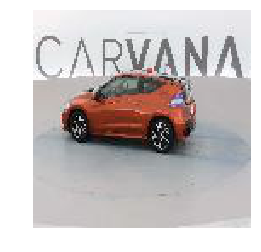

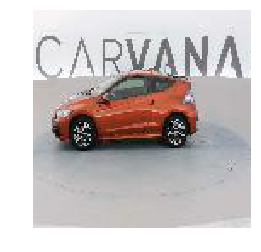

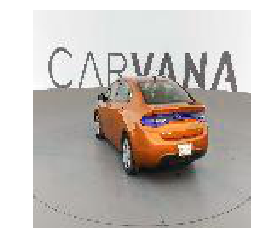

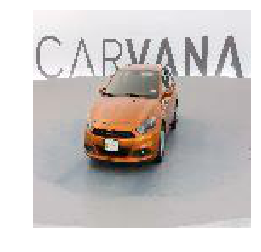

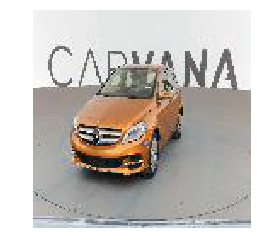

KeyboardInterrupt: 

In [109]:
for i in range(len(predictions)):
    if db.labels_[i] == 1:
        plt.imshow(x[i])
        plt.axis('off')
        plt.show()